<a href="https://colab.research.google.com/github/PKKarna/MyQuantProjects/blob/master/UST_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
<ipython-input-5-642dabc22de5>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  treasury_monthly = treasury_yield.resample('M').last()


MultiIndex([( 'Close', '^TNX'),
            (  'High', '^TNX'),
            (   'Low', '^TNX'),
            (  'Open', '^TNX'),
            ('Volume', '^TNX')],
           names=['Price', 'Ticker'])


<Figure size 1400x700 with 0 Axes>

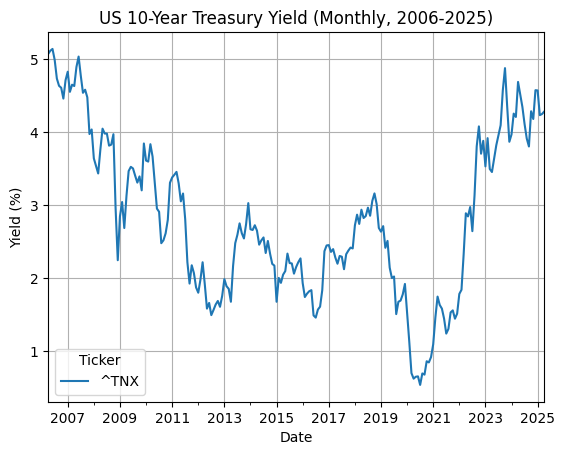

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from math import sqrt
import yfinance as yf
from datetime import datetime

# Fetch US 10-Year Treasury yield data
def fetch_treasury_data():
    # Using Yahoo Finance as a proxy (^TNX is the symbol for CBOE 10-Year Treasury Note Yield)
    end_date = datetime.now().strftime('%Y-%m-%d')
    data = yf.download('^TNX', start='2006-04-15', end=end_date)

    # Print the available columns to check for 'Adj Close'
    print(data.columns)

    # If 'Adj Close' is not present, try 'Close'
    if 'Adj Close' not in data.columns:
        return data['Close']
    else:
        return data['Adj Close']

# Load and prepare the data
treasury_yield = fetch_treasury_data()

# Handle missing values (if any)
treasury_yield = treasury_yield.asfreq('D').ffill()  # Forward fill for weekends/holidays

# Convert to monthly data by taking end-of-month values
treasury_monthly = treasury_yield.resample('M').last()

# Plot the data
plt.figure(figsize=(14, 7))
treasury_monthly.plot(title='US 10-Year Treasury Yield (Monthly, 2006-2025)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.show()

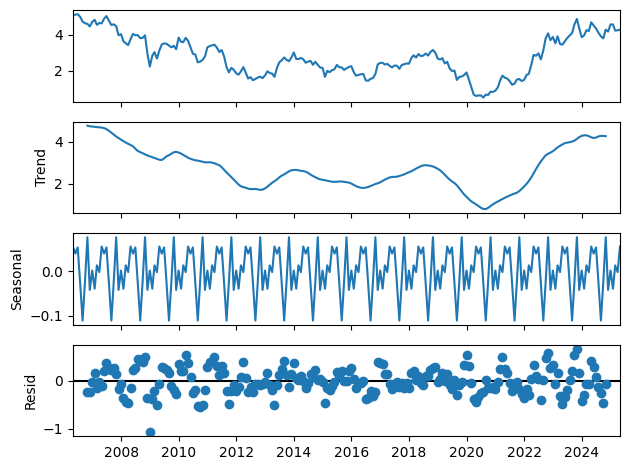

ADF Statistic: -2.266405271864066
p-value: 0.18303190252897378
Critical Values:
   1%: -3.4594900381360034
   5%: -2.8743581895178485
   10%: -2.573601605503697
Series is not stationary


In [6]:
def analyze_stationarity(series):
    # Plot the series and its components
    decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=12)
    decomposition.plot()
    plt.tight_layout()
    plt.show()

    # Perform ADF test
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

analyze_stationarity(treasury_monthly)

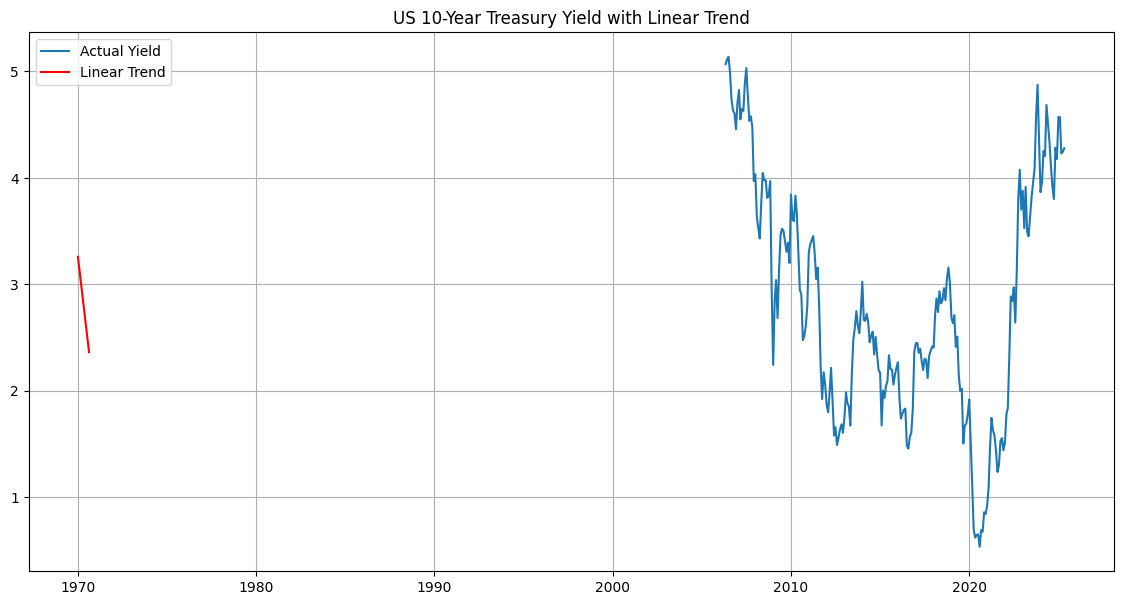


Linear Trend Model Summary:
                            OLS Regression Results                            
Dep. Variable:                   ^TNX   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     13.28
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           0.000333
Time:                        12:18:42   Log-Likelihood:                -341.20
No. Observations:                 229   AIC:                             686.4
Df Residuals:                     227   BIC:                             693.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2593  

<Figure size 1400x700 with 0 Axes>

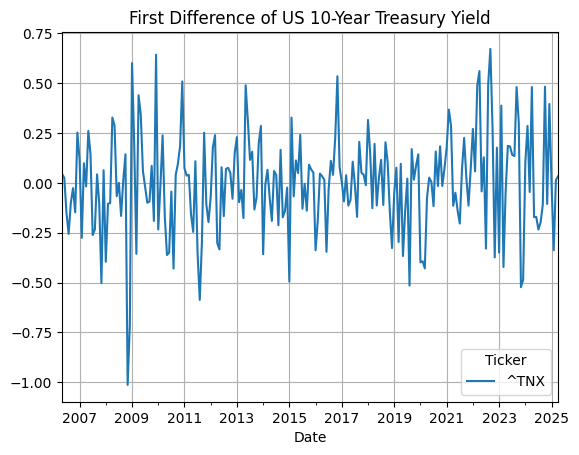

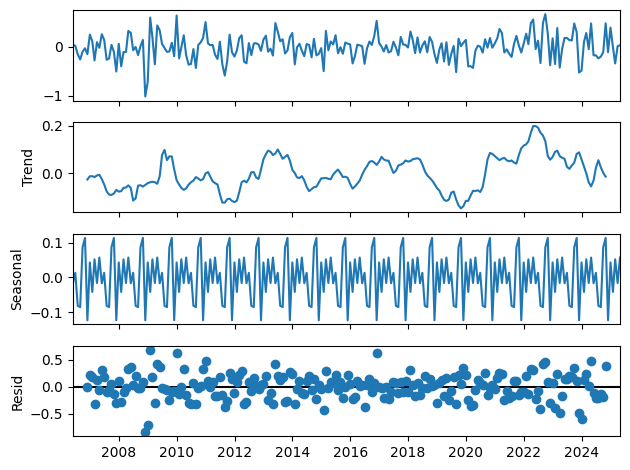

ADF Statistic: -13.63604700261521
p-value: 1.687615076085708e-25
Critical Values:
   1%: -3.4594900381360034
   5%: -2.8743581895178485
   10%: -2.573601605503697
Series is stationary


In [7]:
# Check for trend and seasonality
def check_trend(series):
    # Fit linear trend model
    X = sm.add_constant(np.arange(len(series)))
    model = sm.OLS(series, X).fit()

    # Plot with trend line
    plt.figure(figsize=(14, 7))
    plt.plot(series, label='Actual Yield')
    plt.plot(model.predict(X), label='Linear Trend', color='red')
    plt.title('US 10-Year Treasury Yield with Linear Trend')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('\nLinear Trend Model Summary:')
    print(model.summary())

    return model

trend_model = check_trend(treasury_monthly)

# First difference to remove trend
treasury_diff = treasury_monthly.diff().dropna()

# Plot differenced series
plt.figure(figsize=(14, 7))
treasury_diff.plot(title='First Difference of US 10-Year Treasury Yield')
plt.grid(True)
plt.show()

# Test stationarity of differenced series
analyze_stationarity(treasury_diff)

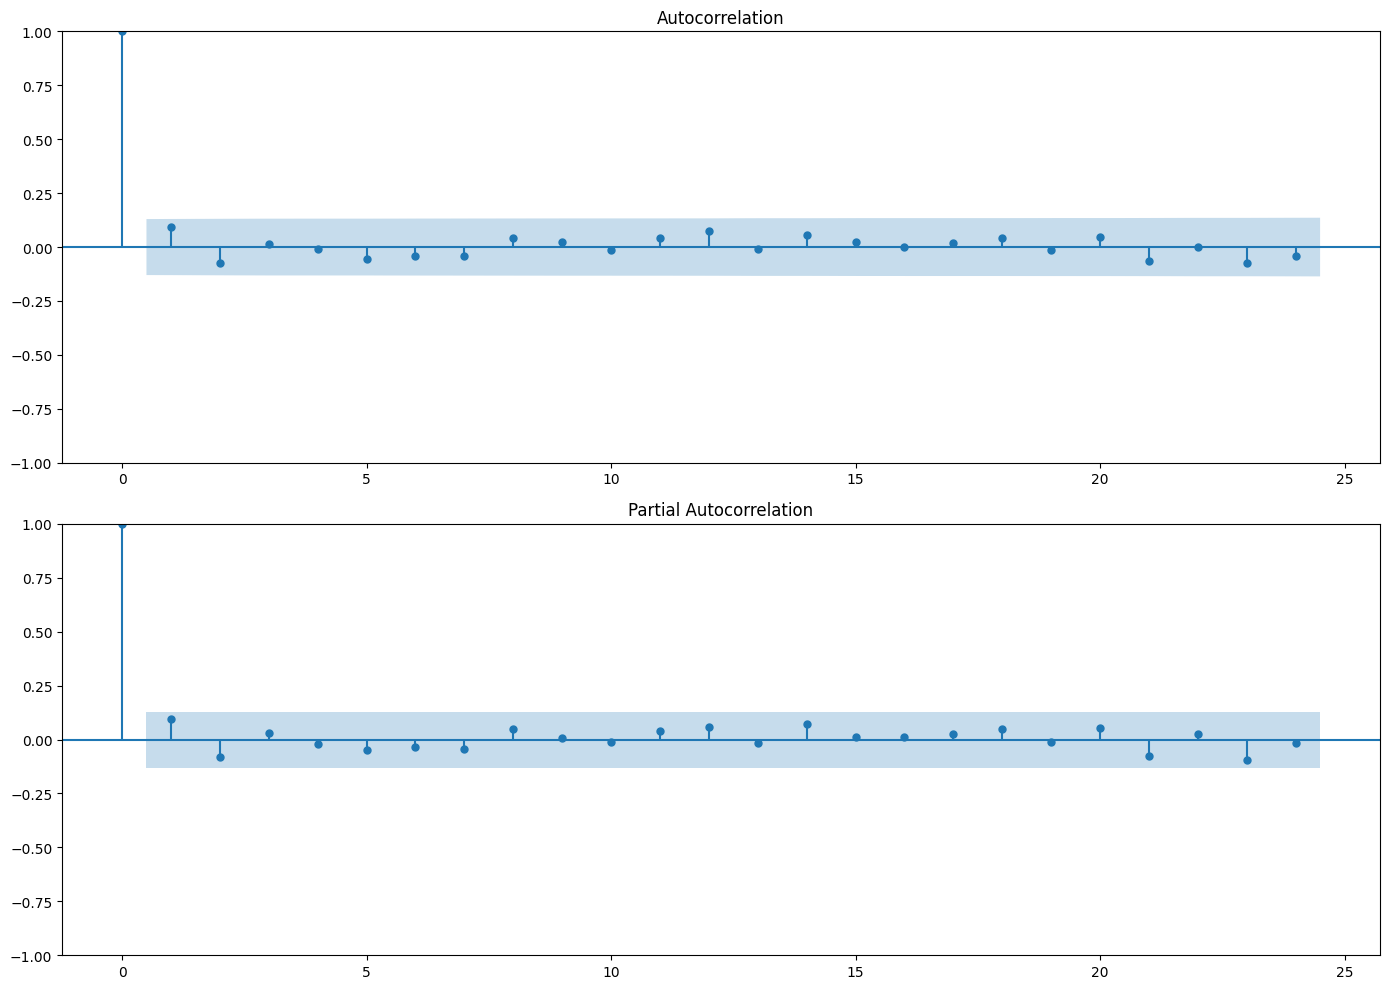

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(treasury_diff, lags=24, ax=ax1)
plot_pacf(treasury_diff, lags=24, ax=ax2)
plt.tight_layout()
plt.show()

# Durbin-Watson test for serial correlation
dw_stat = durbin_watson(treasury_diff)
print(f'Durbin-Watson Statistic: {dw_stat:.4f}')
if dw_stat < 1.5:
    print('Strong positive serial correlation')
elif dw_stat > 2.5:
    print('Strong negative serial correlation')
else:
    print('Little to no serial correlation')

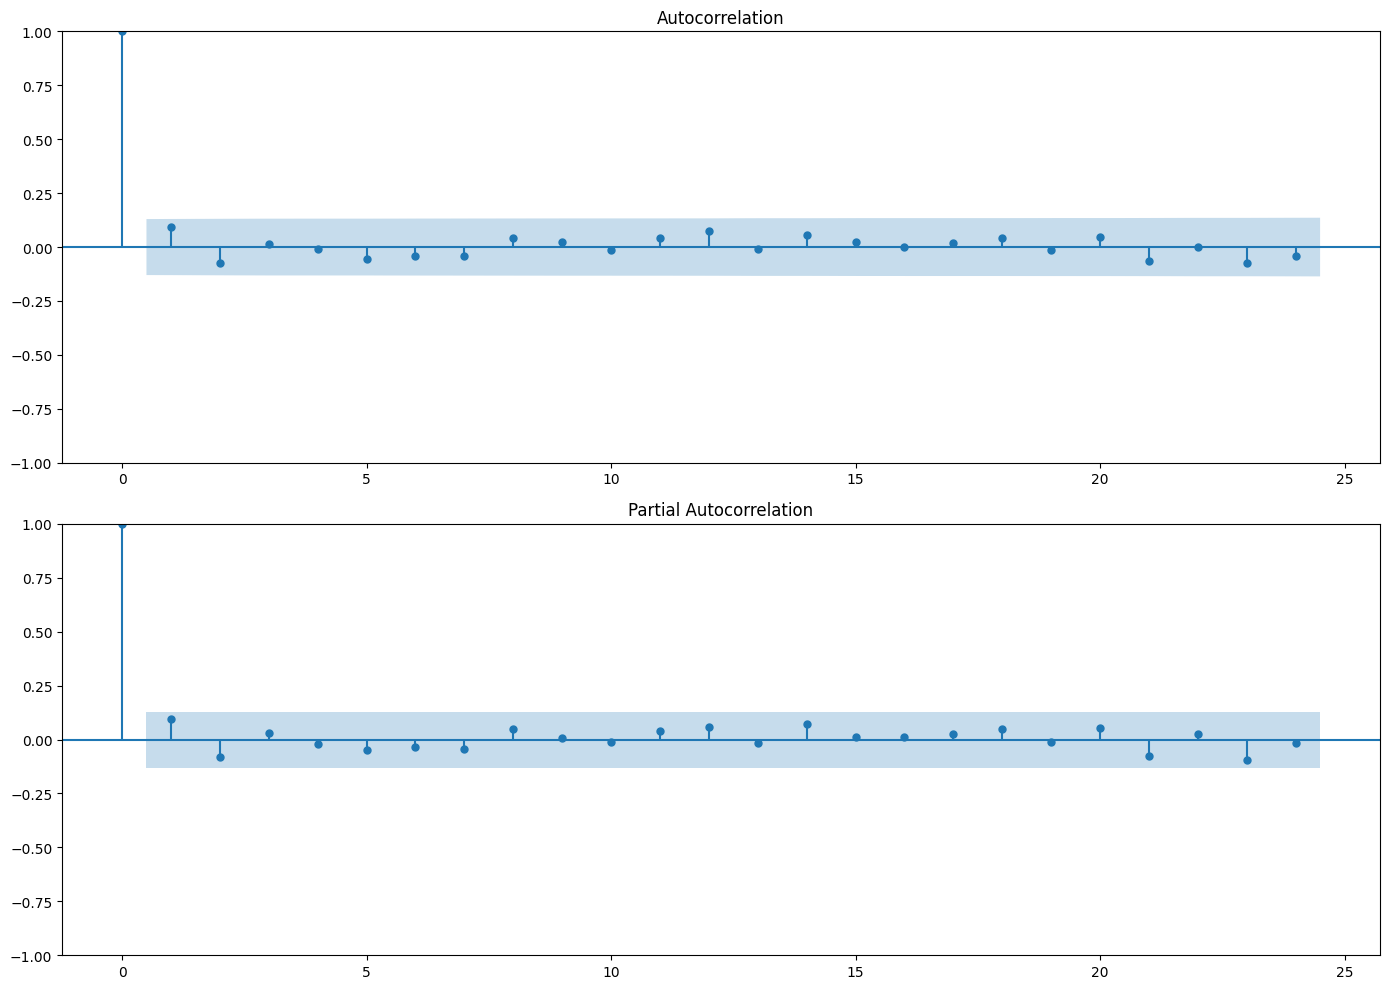

Durbin-Watson Statistic: 1.8093
Little to no serial correlation


In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(treasury_diff, lags=24, ax=ax1)
plot_pacf(treasury_diff, lags=24, ax=ax2)
plt.tight_layout()
plt.show()

# Durbin-Watson test for serial correlation
dw_stat = durbin_watson(treasury_diff)
# Access the first element of the array to get the statistic as a float
print(f'Durbin-Watson Statistic: {dw_stat[0]:.4f}')
if dw_stat[0] < 1.5:
    print('Strong positive serial correlation')
elif dw_stat[0] > 2.5:
    print('Strong negative serial correlation')
else:
    print('Little to no serial correlation')

                               SARIMAX Results                                
Dep. Variable:                   ^TNX   No. Observations:                  229
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -5.690
Date:                Thu, 17 Apr 2025   AIC                             17.381
Time:                        12:28:34   BIC                             27.669
Sample:                    04-30-2006   HQIC                            21.531
                         - 04-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3974      0.414     -0.960      0.337      -1.209       0.414
ma.L1          0.5116      0.394      1.298      0.194      -0.261       1.284
sigma2         0.0615      0.005     12.798      0.0

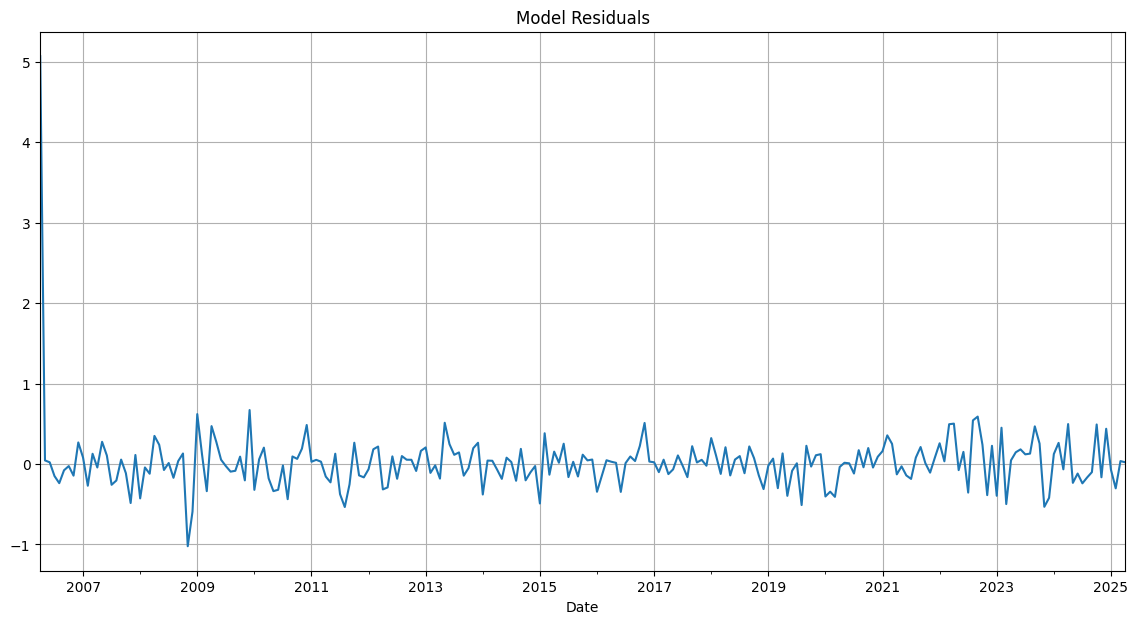


Ljung-Box Test for Residual Autocorrelation:
     lb_stat  lb_pvalue
10  1.895895   0.997078


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model based on ACF/PACF analysis
def fit_arima(series, order):
    model = ARIMA(series, order=order).fit()
    print(model.summary())

    # Plot residuals
    residuals = model.resid
    plt.figure(figsize=(14, 7))
    residuals.plot(title='Model Residuals')
    plt.grid(True)
    plt.show()

    # Ljung-Box test for residual autocorrelation
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print('\nLjung-Box Test for Residual Autocorrelation:')
    print(lb_test)

    return model

# Start with ARIMA(1,1,1) as initial model
arima_model = fit_arima(treasury_monthly, order=(1,1,1))

# If residuals show autocorrelation, try different orders
if acorr_ljungbox(arima_model.resid, lags=[10], return_df=True).lb_pvalue[10] < 0.05:
    print('\nTrying ARIMA(2,1,2) due to residual autocorrelation')
    arima_model = fit_arima(treasury_monthly, order=(2,1,2))

In [15]:
from arch import arch_model

# Test for ARCH effects
def test_arch_effects(residuals):
    # ARCH-LM test
    test_result = acorr_ljungbox(residuals**2, lags=[10], return_df=True)
    print('\nARCH-LM Test (Ljung-Box on squared residuals):')
    print(test_result)

    if test_result.lb_pvalue[10] < 0.05:
        print('\nSignificant ARCH effects detected')
        return True
    else:
        print('\nNo significant ARCH effects')
        return False

# Fit GARCH model if ARCH effects are present
if test_arch_effects(arima_model.resid):
    print('\nFitting GARCH(1,1) model')
    garch = arch_model(arima_model.resid, vol='Garch', p=1, q=1)
    garch_fitted = garch.fit(update_freq=5)
    print(garch_fitted.summary())

    # Plot conditional volatility
    plt.figure(figsize=(14, 7))
    plt.plot(garch_fitted.conditional_volatility)
    plt.title('Conditional Volatility of Treasury Yield Residuals')
    plt.grid(True)
    plt.show()


ARCH-LM Test (Ljung-Box on squared residuals):
     lb_stat  lb_pvalue
10  0.006881        1.0

No significant ARCH effects


In [12]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 14.2 MB/s eta 0:00:00


In [16]:
def evaluate_forecast(series, model, steps=24):
    # Split into train and test (last 2 years as test)
    train = series[:-steps]
    test = series[-steps:]

    # Refit model on training data
    refit_model = ARIMA(train, order=model.order).fit()

    # Forecast
    forecast = refit_model.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, forecast_mean))
    print(f'\nOut-of-sample RMSE: {rmse:.4f}')

    # Plot forecasts
    plt.figure(figsize=(14, 7))
    plt.plot(series, label='Actual')
    plt.plot(forecast_mean, label='Forecast', color='red')
    plt.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'US 10-Year Treasury Yield Forecast (Last {steps} Months)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rmse

# Evaluate ARIMA model forecast
forecast_rmse = evaluate_forecast(treasury_monthly, arima_model)

# Compare with naive forecast (last value)
naive_forecast = np.full_like(treasury_monthly[-24:], treasury_monthly[-25])
naive_rmse = sqrt(mean_squared_error(treasury_monthly[-24:], naive_forecast))
print(f'\nNaive Forecast RMSE: {naive_rmse:.4f}')
print(f'ARIMA Model Improvement: {(naive_rmse-forecast_rmse)/naive_rmse:.2%}')

AttributeError: 'ARIMAResults' object has no attribute 'order'


Out-of-sample RMSE: 0.8006


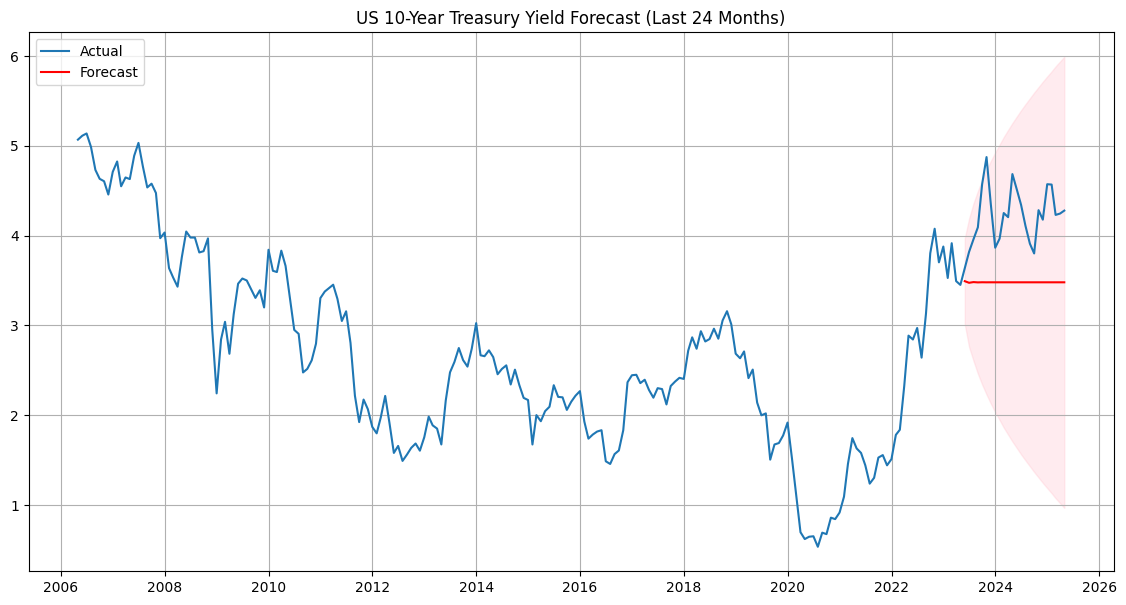

KeyError: -25

In [17]:
def evaluate_forecast(series, model_order, steps=24):  # Changed: Pass model_order
    # Split into train and test (last 2 years as test)
    train = series[:-steps]
    test = series[-steps:]

    # Refit model on training data
    refit_model = ARIMA(train, order=model_order).fit()  # Use model_order

    # Forecast
    forecast = refit_model.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, forecast_mean))
    print(f'\nOut-of-sample RMSE: {rmse:.4f}')

    # Plot forecasts
    plt.figure(figsize=(14, 7))
    plt.plot(series, label='Actual')
    plt.plot(forecast_mean, label='Forecast', color='red')
    plt.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'US 10-Year Treasury Yield Forecast (Last {steps} Months)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rmse

# Evaluate ARIMA model forecast
# Pass the order used in the initial model fit
forecast_rmse = evaluate_forecast(treasury_monthly, arima_model.model.order)

# Compare with naive forecast (last value)
naive_forecast = np.full_like(treasury_monthly[-24:], treasury_monthly[-25])
naive_rmse = sqrt(mean_squared_error(treasury_monthly[-24:], naive_forecast))
print(f'\nNaive Forecast RMSE: {naive_rmse:.4f}')
print(f'ARIMA Model Improvement: {(naive_rmse-forecast_rmse)/naive_rmse:.2%}')


Out-of-sample RMSE: 0.8006


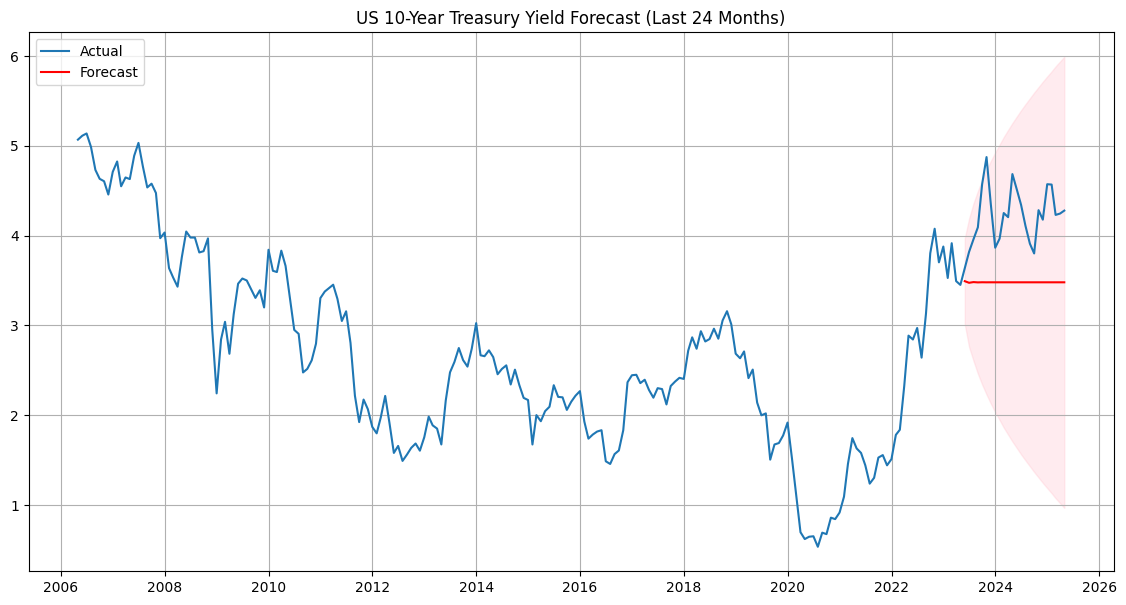


Naive Forecast RMSE: 0.8273
ARIMA Model Improvement: 3.23%


In [18]:
def evaluate_forecast(series, model_order, steps=24):  # Changed: Pass model_order
    # Split into train and test (last 2 years as test)
    train = series[:-steps]
    test = series[-steps:]

    # Refit model on training data
    refit_model = ARIMA(train, order=model_order).fit()  # Use model_order

    # Forecast
    forecast = refit_model.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, forecast_mean))
    print(f'\nOut-of-sample RMSE: {rmse:.4f}')

    # Plot forecasts
    plt.figure(figsize=(14, 7))
    plt.plot(series, label='Actual')
    plt.plot(forecast_mean, label='Forecast', color='red')
    plt.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'US 10-Year Treasury Yield Forecast (Last {steps} Months)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rmse

# Evaluate ARIMA model forecast
# Pass the order used in the initial model fit
forecast_rmse = evaluate_forecast(treasury_monthly, arima_model.model.order)

# Compare with naive forecast (last value)
# Change: Use .iloc to access by position instead of index
naive_forecast = np.full_like(treasury_monthly[-24:], treasury_monthly.iloc[-25])
naive_rmse = sqrt(mean_squared_error(treasury_monthly[-24:], naive_forecast))
print(f'\nNaive Forecast RMSE: {naive_rmse:.4f}')
print(f'ARIMA Model Improvement: {(naive_rmse-forecast_rmse)/naive_rmse:.2%}')

                        Markov Switching Model Results                        
Dep. Variable:                   ^TNX   No. Observations:                  229
Model:               MarkovRegression   Log Likelihood                -227.238
Date:                Thu, 17 Apr 2025   AIC                            464.477
Time:                        12:32:23   BIC                            481.645
Sample:                    04-30-2006   HQIC                           471.403
                         - 04-30-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1011      0.056     37.781      0.000       1.992       2.210
                             Regime 1 parameters    

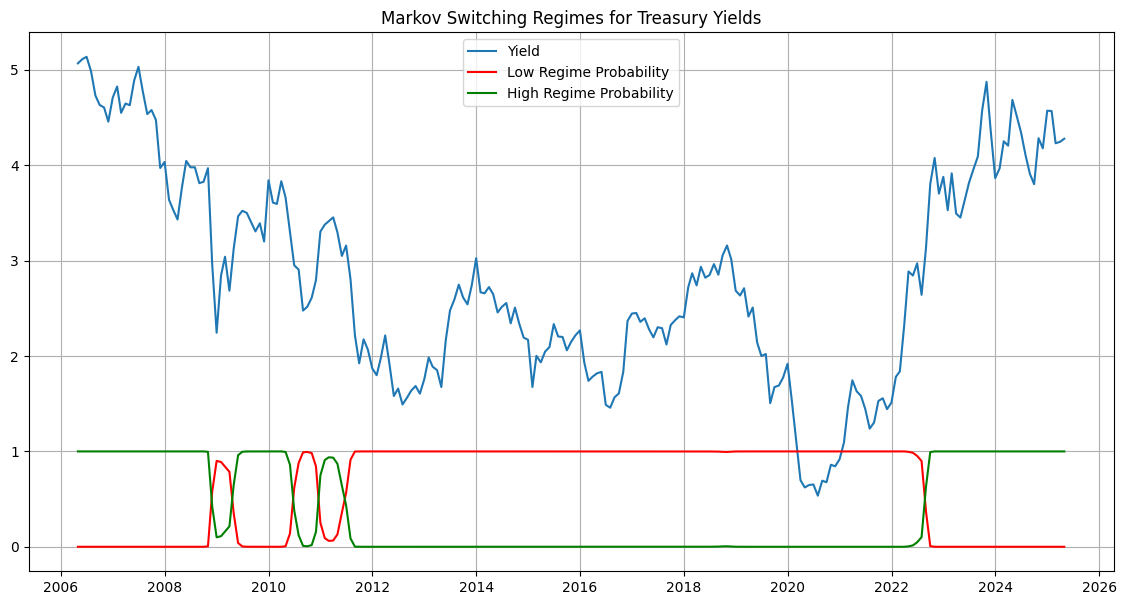

In [19]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Check for structural breaks (financial crisis, COVID, etc.)
def detect_structural_breaks(series):
    # Using Markov Switching Model
    mod = MarkovRegression(series.dropna(), k_regimes=2, trend='c')
    res = mod.fit()
    print(res.summary())

    # Plot regimes
    plt.figure(figsize=(14, 7))
    plt.plot(series, label='Yield')
    plt.plot(res.smoothed_marginal_probabilities[0], label='Low Regime Probability', color='red')
    plt.plot(res.smoothed_marginal_probabilities[1], label='High Regime Probability', color='green')
    plt.title('Markov Switching Regimes for Treasury Yields')
    plt.legend()
    plt.grid(True)
    plt.show()

detect_structural_breaks(treasury_monthly)

Conclusion
This analysis provides a comprehensive examination of the US 10-Year Treasury yield:

We identified non-stationarity and applied differencing

Developed ARIMA models based on ACF/PACF analysis

Detected and modeled volatility clustering with GARCH

Evaluated forecast performance against a naive benchmark

Examined structural breaks in the series

Key insights from this analysis:

The yield series shows clear periods of different volatility regimes

ARIMA models can capture the serial dependence in yields

Volatility clustering is present, suggesting GARCH effects

Structural breaks correspond to major financial events

To further improve the analysis:

Incorporate macroeconomic variables as exogenous factors

Test for cointegration with other yield curve points

Explore machine learning approaches for forecasting

Implement more sophisticated structural break detection